In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import spacy
from collections import Counter

#somewhere look at num of unique lemma tokens!!!!!!!!!


In [2]:
df = pd.read_csv("taylor_swift_lyrics.csv",encoding = "latin1")

In [3]:
df.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [4]:
df.shape

(4862, 7)

In [5]:
#albums does not inclue folklore
df.album.unique()

array(['Taylor Swift', 'Fearless', 'Speak Now', 'Red', '1989',
       'reputation'], dtype=object)

In [6]:
#start off looking at a whole song?
num_songs = len(df.track_title.unique())
print(f'there are {num_songs} songs in the dataset')

there are 94 songs in the dataset


In [7]:
#avg lines in all song
df.describe()

,track_n,line,year
count,4862.000000,4862.000000,4862.000000
mean,8.216989,28.426573,2011.882764
std,4.696379,18.343649,3.571447
min,1.000000,1.000000,2006.000000
25%,4.000000,13.000000,2010.000000
50%,8.000000,26.000000,2012.000000
75%,12.000000,41.000000,2014.000000
max,19.000000,101.000000,2017.000000


In [8]:
# lets look at hist of songs by total lines
df.groupby('track_title',as_index=False)['line'].count()

,track_title,line
0,...Ready for It?,61
1,22,53
2,A Perfectly Good Heart,23
3,A Place In This World,27
4,All Too Well,47
...,...,...
89,Wildest Dreams,58
90,Wonderland,67
91,You Are in Love,45
92,You Belong With Me,49


In [9]:
px.histogram(df,x='track_title',y='line',color='album',histfunc='count',orientation='v',height=800,title="num of lines per song")

In [10]:
#leads me to think i can have a complezxity of song metric? total words/num lines?

In [11]:
foo = df.drop_duplicates(subset=['track_title'])
px.histogram(foo,x='album',y='track_title',color='album',histfunc='count',orientation='v', title="num tracks in album")

# nlp word analysis of lyrics

In [12]:
# #now lets look at the lyrics!

# nlp = spacy.load('en_core_web_lg')

In [13]:
# # #add merge entities and merging noun chunks
# merge_ents = nlp.create_pipe("merge_entities")
# nlp.add_pipe(merge_ents)

# #essentially phrase modeling
# merge_nps = nlp.create_pipe("merge_noun_chunks")
# nlp.add_pipe(merge_nps)

In [10]:
#check if merging noun chunks would help in lda?
from sense2vec import Sense2VecComponent

nlp = spacy.load("en_core_web_lg")
s2v = Sense2VecComponent(nlp.vocab).from_disk("s2v_reddit_2019_lg")
nlp.add_pipe(s2v)
# #add merge entities and merging noun chunks
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)


In [8]:
doc = nlp("A sentence about natural language processing.")
assert doc[3:6].text == "natural language processing"
freq = doc[3:6]._.s2v_freq
vector = doc[3:6]._.s2v_vec
most_similar = doc[3:6]._.s2v_most_similar(3)

In [20]:
doc[3:6]._.in_s2v
doc[3:6]._.s2v_most_similar()

[(('machine learning', 'NOUN'), 0.772),
 (('NLP', 'ORG'), 0.7007),
 (('computer vision', 'NOUN'), 0.6968),
 (('text mining', 'NOUN'), 0.693),
 (('deep learning', 'NOUN'), 0.6911),
 (('Machine Learning', 'ORG'), 0.691),
 (('speech recognition', 'NOUN'), 0.682),
 (('image generation', 'NOUN'), 0.6809),
 (('machine learning algorithms', 'NOUN'), 0.6793),
 (('deep reinforcement learning', 'NOUN'), 0.6761)]

In [16]:
dir(doc[3:6]._)

['get',
 'has',
 'in_s2v',
 's2v_freq',
 's2v_key',
 's2v_most_similar',
 's2v_other_senses',
 's2v_similarity',
 's2v_vec',
 'set',
 'trf_alignment',
 'trf_all_attentions',
 'trf_all_hidden_states',
 'trf_d_all_attentions',
 'trf_d_all_hidden_states',
 'trf_d_last_hidden_state',
 'trf_d_pooler_output',
 'trf_end',
 'trf_last_hidden_state',
 'trf_pooler_output',
 'trf_segments',
 'trf_separator',
 'trf_start',
 'trf_word_pieces',
 'trf_word_pieces_']

In [12]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x17dd45b50>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x17ef6d8a0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x17ef6d520>),
 ('sense2vec', <sense2vec.component.Sense2VecComponent at 0x17e4d8210>),
 ('merge_entities', <function spacy.pipeline.functions.merge_entities(doc)>)]

In [15]:
#need to add some stop words "la" is not a named entity in fifteen. "ey" in wonderland should be stop, e in last time, 'ha'
#look at parser,tokenizer in displaycy


customize_stop_words = [
    'la', 'ey','ha','mmm'
]
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [16]:
from functools import reduce

def concat_lyrics(series):
    return reduce(lambda x, y: x + ", " + y, series)

In [17]:
#look at the content of inndividual songs
left = df.groupby('track_title',as_index=False).agg({'lyric': concat_lyrics})
right = df[['track_title','album']].drop_duplicates(subset=['track_title'])
track_df = pd.merge(left,right,on='track_title',how='left')

In [18]:
track_df.head()

,track_title,lyric,album
0,...Ready for It?,Knew he was a killer first time that I saw him...,reputation
1,22,It feels like a perfect night to dress up like...,Red
2,A Perfectly Good Heart,Why would you wanna break a perfectly good hea...,Taylor Swift
3,A Place In This World,"I don't know what I want, so don't ask me, Cau...",Taylor Swift
4,All Too Well,"I walked through the door with you, the air wa...",Red


In [19]:
#tokenize 
track_tokens = list(nlp.pipe(track_df.lyric))

In [20]:
type(track_tokens[0][0])

spacy.tokens.token.Token

In [21]:
track_df['tokens'] = track_tokens

In [22]:
def lemmatize(doc):
    '''
    cleans stopwords punctuation and lemmatizes doc of tokens
    returns a list of cleaned tokens
    '''
    temp = list(filter(lambda x: x.is_stop==False,doc))
    temp2 = list(filter(lambda x: x.is_punct==False,temp))
    lemmas = (list(map(lambda x: x.text if x.pos_ == 'PRON' else x.lemma_ , temp2)))

    return lemmas

In [23]:
track_df['lemma'] = [lemmatize(x) for x in track_tokens]

In [24]:
track_df[track_df.track_title== 'Shake It Off']

,track_title,lyric,album,tokens,lemma
61,Shake It Off,"I stay out too late, Got nothing in my brain, ...",1989,"(I, stay, out, too, late, ,, Got, nothing, in,...","[stay, late, get, brain, people, people, date,..."


In [25]:
track_df.track_title[61]

'Shake It Off'

In [26]:
print(track_df.lyric[61])

I stay out too late, Got nothing in my brain, That's what people say, mmm, mmm, That's what people say, mmm, mmm, I go on too many dates, But I can't make them stay, At least that's what people say, mmm, mmm, That's what people say, mmm, mmm, But I keep cruisin', Can't stop, won't stop movin', It's like I got this music in my mind, Saying it's gonna be alright, 'Cause the players gonna play, play, play, play, play, And the haters gonna hate, hate, hate, hate, hate, Baby, I'm just gonna shake, shake, shake, shake, shake, I shake it off,  I shake it off, Heartbreakers gonna break, break, break, break, break, And the fakers gonna fake, fake, fake, fake, fake, Baby, I'm just gonna shake, shake, shake, shake, shake, I shake it off, I shake it off, I never miss a beat, I'm lightning on my feet, And that's what they don't see, mmm, mmm, That's what they don't see, mmm, mmm, I'm dancing on my own (dancing on my own), I make the moves up as I go (moves up as I go), And that's what they don't kn

In [27]:
print(track_df.lemma[61])

['stay', 'late', 'get', 'brain', 'people', 'people', 'date', 'stay', 'people', 'people', 'cruisin', 'stop', 'will', 'stop', 'movin', 'like', 'get', 'music', 'mind', 'say', 'go', 'to', 'alright', 'because', 'player', 'go', 'to', 'play', 'play', 'play', 'play', 'play', 'hater', 'go', 'to', 'hate', 'hate', 'hate', 'hate', 'hate', 'Baby', 'go', 'to', 'shake', 'shake', 'shake', 'shake', 'shake', 'shake', ' ', 'shake', 'Heartbreakers', 'go', 'to', 'break', 'break', 'break', 'break', 'break', 'faker', 'go', 'to', 'fake', 'fake', 'fake', 'fake', 'fake', 'Baby', 'go', 'to', 'shake', 'shake', 'shake', 'shake', 'shake', 'shake', 'shake', 'miss', 'beat', 'lightne', 'foot', 'dance', 'dance', 'move', 'move', 'know', 'know', 'cruisin', 'stop', 'will', 'stop', 'groovin', 'like', 'get', 'music', 'mind', 'say', 'go', 'to', 'alright', 'because', 'player', 'go', 'to', 'play', 'play', 'play', 'play', 'play', 'hater', 'go', 'to', 'hate', 'hate', 'hate', 'hate', 'hate', 'Baby', 'go', 'to', 'shake', 'shake', 

In [28]:
#compute term freq dic of each word(see how many times she repeats herself) are we out of the woods?
def term_frequency(doc):
    '''computes term frequency for list of tokens'''
    c = Counter(doc)
    doc_len = len(doc)
    return {i: v/len(doc) for i,v in c.items()}

In [29]:
track_df['term_freq'] = track_df.lemma.apply(lambda x: term_frequency(x))

In [30]:
# can edit to gapichally display tf dataframe maybe change count or add tfidf score 
# also need to figure out how to do with explode and or melt not sure pandas 

f = []
temp = track_df[['track_title','lemma','term_freq','album']].set_index('track_title')
for title in list(temp.index):
    
    c = Counter(temp.loc[title].lemma)
    
    word_counts = pd.DataFrame(c.items())
    word_counts.columns = ['word','count']
    word_counts['title'] = title
    
    #append term freq TODO
    tf_counts = pd.DataFrame(temp.loc[title].term_freq.items())
    tf_counts.columns = ['word','tf']
    tf_counts['title'] = title
    tf_counts['album'] = temp.loc[title].album
    
    
    f.append(pd.merge(word_counts,tf_counts,on=['word','title'],how='left'))

In [31]:
frame = pd.concat(f)

In [32]:
frame.reset_index(inplace=True)
frame.drop(columns='index',inplace=True)

In [33]:
frame.sort_values('tf', ascending=False, inplace=True)

In [34]:
#notice some very oultlier term freq within a song
px.histogram(frame,x='tf',log_y=True)

In [35]:
px.bar(frame[frame.tf>.1].drop_duplicates(subset=['word']), x="word", y="tf", color="album",hover_data=['word','title'])

### album lyr

In [36]:
#analysis of lyrics grouped by album can prob just use this same dataframe with another groupby
#look into lyric diversity using Measure of Textual Lexical Diversity
# REFACTOR

In [37]:
lyrics_album = df.groupby('album',as_index=False).agg({'lyric': concat_lyrics})

In [38]:
# have all tokens now seperated by album
lyrics_album['tokens'] = lyrics_album.lyric.apply(lambda x: nlp(x))

In [39]:
lyrics_album

,album,lyric,tokens
0,1989,"Walking through a crowd, the village is aglow,...","(Walking, through, a, crowd, ,, the, village, ..."
1,Fearless,"There's something 'bout the way, The street lo...","(There, 's, something, 'bout, the, way, ,, The..."
2,Red,"I'm walking fast through the traffic lights, B...","(I, 'm, walking, fast, through, the, traffic, ..."
3,Speak Now,"You were in college, working part-time, waitin...","(You, were, in, college, ,, working, part, -, ..."
4,Taylor Swift,"He said the way my blue eyes shined, Put those...","(He, said, the, way, my, blue, eyes, shined, ,..."
5,reputation,Knew he was a killer first time that I saw him...,"(Knew, he, was, a, killer, first, time, that, ..."


In [40]:
albums = list(lyrics_album.album.values)
lyrics_album.album.values

array(['1989', 'Fearless', 'Red', 'Speak Now', 'Taylor Swift',
       'reputation'], dtype=object)

In [41]:
import collections

f = []
temp = lyrics_album.set_index('album')
for album in albums:
    print(album)
    d = (list(filter(lambda x: x.is_stop==False,temp.loc[album].tokens)))
    d = (list(filter(lambda x: x.is_punct==False, d)))
    d = (list(map(lambda x: x.lemma_, d)))
    
    c = collections.Counter(d)
    
    word_counts = pd.DataFrame(c.items())
    word_counts.columns = ['word','count']
    word_counts['album'] = album
    
    f.append(word_counts)
    

1989
Fearless
Red
Speak Now
Taylor Swift
reputation


In [42]:
temp = lyrics_album.set_index('album')
type(temp.loc['1989'].tokens)

spacy.tokens.doc.Doc

In [43]:
counts_per = pd.concat(f)

In [44]:
counts_per.sort_values('count', ascending=False, inplace=True)

In [45]:
#repetitivness of a word in an album
px.bar(counts_per[:20], x="count", y="word", color="album", orientation='h',title="top 20 word freq by album", log_x=True)

In [46]:
#above interesting some most popular words only mentioned in one album!! smh headspin

In [47]:
df['tokens'] = df.lyric.apply(lambda x: nlp(x))

In [48]:
# for i, doc in enumerate(df.tokens):
#     for ent in doc.ents:
#          print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [49]:
#create word frequency
word_freq = {}
for doc in df.tokens:
    for ent in doc.ents:
        word_freq[ent.text] = word_freq.get(ent.text,0) + 1

In [50]:
word_counts = pd.DataFrame(word_freq.items())
word_counts.columns = ['word','count']
word_counts.sort_values('count', ascending=False, inplace=True)

In [51]:
px.bar(word_counts[3:75],x='count', y='word', orientation='h'
      ,width=800, height=700,log_x=True)

In [52]:
#cluster based on word vectors tsne?

In [53]:
track_df.head()

,track_title,lyric,album,tokens,lemma,term_freq
0,...Ready for It?,Knew he was a killer first time that I saw him...,reputation,"(Knew, he, was, a, killer, first, time, that, ...","[know, killer, time, see, wonder, girl, love, ...","{'know': 0.057692307692307696, 'killer': 0.006..."
1,22,It feels like a perfect night to dress up like...,Red,"(It, feels, like, a, perfect, night, to, dress...","[feel, like, perfect, night, dress, like, hips...","{'feel': 0.06547619047619048, 'like': 0.101190..."
2,A Perfectly Good Heart,Why would you wanna break a perfectly good hea...,Taylor Swift,"(Why, would, you, wanna, break, a, perfectly, ...","[wanna, break, perfectly, good, heart, wanna, ...","{'wanna': 0.1951219512195122, 'break': 0.09756..."
3,A Place In This World,"I don't know what I want, so don't ask me, Cau...",Taylor Swift,"(I, do, n't, know, what, I, want, ,, so, do, n...","[know, want, ask, cause, try, figure, know, ro...","{'know': 0.07058823529411765, 'want': 0.011764..."
4,All Too Well,"I walked through the door with you, the air wa...",Red,"(I, walked, through, the, door, with, you, ,, ...","[walk, door, air, cold, about, feel, like, hom...","{'walk': 0.0125, 'door': 0.00625, 'air': 0.006..."


In [54]:
track_df.shape

(94, 6)

In [55]:
# #get sum of sense2vec
# def docvec(doc):
#     toks = []
#     for token in doc:
#         toks.append(token._.s2v_vec)

In [58]:
if track_df.tokens[0][37]._.s2v_vec == None

SyntaxError: invalid syntax (<ipython-input-58-cb3b11d7b405>, line 1)

In [59]:
l = []
for token in track_df.tokens[0]:
    if token._.in_s2v:
        l.append(token._.s2v_vec)
    else:
        l.append(token.vector)

    

In [60]:
len(track_df.tokens[0])

556

In [62]:
np.linalg.norm(track_df.tokens[0][0].vector)

5.5257206

In [63]:
from sklearn.manifold import TSNE

In [66]:
song_vectors = np.vstack([doc.vector for doc in track_df.tokens])

In [67]:
X_embedded = TSNE(n_components=2).fit_transform(song_vectors)

In [68]:
X_embedded.shape

(94, 2)

In [69]:
X_embedded[0]

array([-37.205833, -16.322819], dtype=float32)

In [70]:
tsne_df = pd.concat([track_df[['track_title','album']],pd.DataFrame(X_embedded)],axis=1)

In [71]:
tsne_df.columns = ['track_title','album','tsne_1','tsne_2']

In [72]:
px.scatter(tsne_df,x='tsne_1',y='tsne_2',color='album',hover_data=['track_title','album'])

In [127]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(list(track_df.lyric))
id2word.filter_extremes(no_above=0.1, no_below=10)

# Create Corpus
lyrics = list(track_df.lemma)
# Term Document Frequency
corpus = [id2word.doc2bow(lyric) for lyric in lyrics]
# View
print(corpus[:1])

[[]]


In [85]:
import gensim
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [87]:
lda_model.print_topics()


[(0,
  '0.033*"know" + 0.032*"like" + 0.023*"want" + 0.019*"go" + 0.018*"because" + 0.016*"get" + 0.012*"baby" + 0.012*"yeah" + 0.010*"feel" + 0.010*"love"'),
 (1,
  '0.039*"look" + 0.024*"know" + 0.019*"like" + 0.014*"time" + 0.013*"say" + 0.013*"tell" + 0.013*"come" + 0.010*"get" + 0.010*"love" + 0.009*"shine"'),
 (2,
  '0.030*"like" + 0.019*"dance" + 0.018*"love" + 0.018*"wanna" + 0.016*"wait" + 0.014*"welcome" + 0.014*"New York" + 0.013*"end" + 0.012*"know" + 0.012*"get"'),
 (3,
  '0.072*"wish" + 0.027*"hold" + 0.018*"right" + 0.018*"beautiful" + 0.018*"know" + 0.013*"time" + 0.013*"sorry" + 0.013*"memory" + 0.012*"love" + 0.012*"burn"'),
 (4,
  '0.028*"oh" + 0.027*"know" + 0.018*"place" + 0.018*"trouble" + 0.017*"time" + 0.016*"love" + 0.015*"like" + 0.015*"wanna" + 0.014*"tell" + 0.014*"because"'),
 (5,
  '0.033*"oh" + 0.033*"ah" + 0.029*"think" + 0.020*"grow" + 0.018*"dress" + 0.015*"like" + 0.013*"say" + 0.012*"little" + 0.011*"aah" + 0.011*"thing"'),
 (6,
  '0.101*"stay" + 0.0

In [84]:
#baseline coherence score 

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list(track_df.lemma), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2980347269084519


In [95]:
import gensim
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [98]:
dictionary = corpora.Dictionary(list(track_df.lemma))
texts = list(track_df.lemma)
corpus = [id2word.doc2bow(lyric) for lyric in lyrics]


In [102]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

ValueError: x and y must have same first dimension, but have shapes (7,) and (38,)

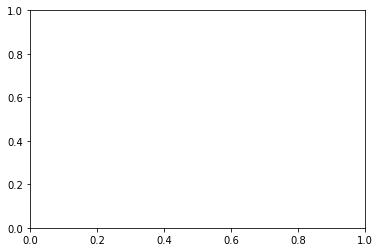

In [105]:

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=40, step=1)


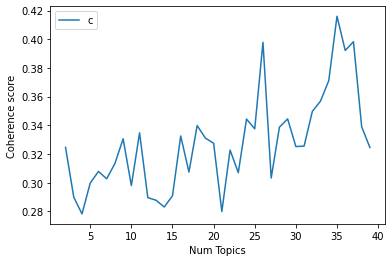

In [106]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [108]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=100, step=5)

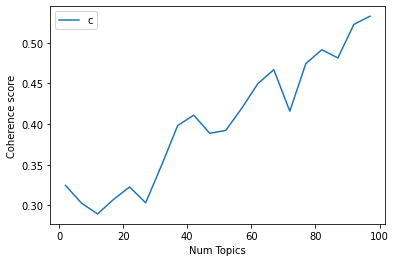

In [109]:
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [110]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=20, step=1)

In [112]:
coherence = pd.DataFrame(coherence_values)

In [115]:
coherence.index = list(range(2,20,1))
coherence.columns = ['score']

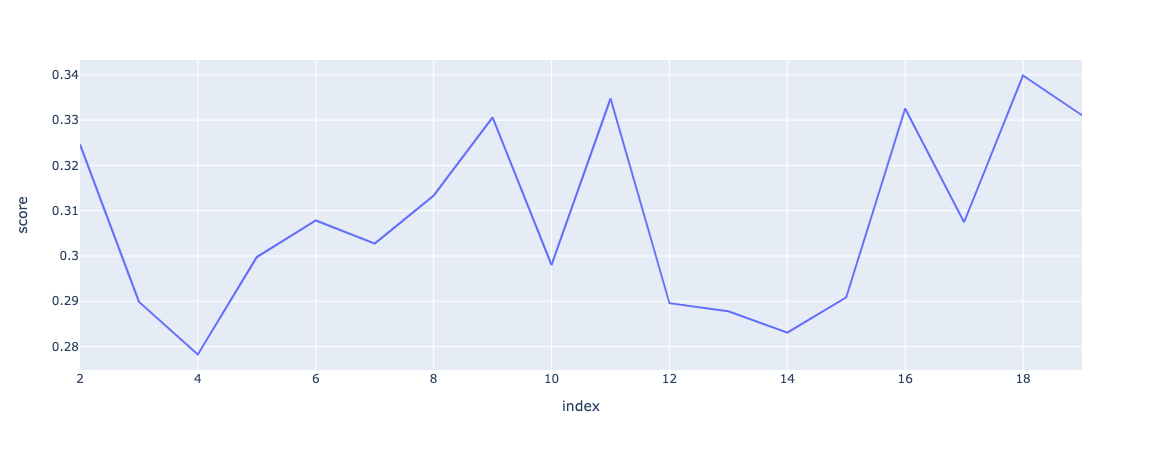

In [117]:
px.line(coherence,y='score')

In [155]:
model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=9, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [156]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [157]:
lyric_lda = pyLDAvis.gensim.prepare(model, corpus, dictionary)


/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [158]:
lyric_lda

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.026177 -0.046720       1        1  20.982745
8      0.044392 -0.006261       2        1  20.087257
3     -0.016437 -0.049169       3        1  13.889089
0     -0.021767 -0.048068       4        1  10.505736
6      0.001420 -0.085343       5        1  10.473781
5     -0.187364  0.091804       6        1   9.503060
1      0.055679  0.007673       7        1   6.531856
7      0.053019 -0.019522       8        1   5.893944
2      0.097234  0.155606       9        1   2.132532, topic_info=       Term        Freq       Total Category  logprob  loglift
758   shake   78.000000   78.000000  Default  30.0000  30.0000
29     know  344.000000  344.000000  Default  29.0000  29.0000
40       oh  239.000000  239.000000  Default  28.0000  28.0000
94     look  123.000000  123.000000  Default  27.0000  27.0000
1752     ey   67.000000   67.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
32    light    1.824364   61.782197   Topic9  -5.0387   0.3255
56       to    1.836834   66.878613   Topic9  -5.0319   0.2530
18     girl    1.795915   69.814704   Topic9  -5.0544   0.1875
33     like    1.902042  256.165338   Topic9  -4.9970  -1.0550
153    tell    1.551915   76.932328   Topic9  -5.2005  -0.0556

[599 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
64        4  0.862579         22
65        4  0.866242      22 22
476       3  0.754497        A.M
882       9  0.490803    Abigail
1         9  0.694042     Burton
...     ...       ...        ...
535       5  0.586548        yes
865       5  0.946776  yesterday
536       1  0.260800         
 
536       3  0.086933         
 
536       6  0.608534         
 

[1253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 1, 7, 6, 2, 8, 3])

In [159]:
pyLDAvis.save_html(lyric_lda, 'lda_NEW_genre_4_topic.html')

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [160]:
lyric_topics = model[corpus]

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [150]:
model.print_topics()

/Users/matt/.pyenv/versions/3.7.7/envs/tswift/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.034*"oh" + 0.021*"know" + 0.017*"ey" + 0.016*"like" + 0.014*"think" + 0.011*"go" + 0.011*"love" + 0.010*"baby" + 0.010*"tell" + 0.010*"wanna"'),
 (1,
  '0.024*"come" + 0.018*"like" + 0.018*"time" + 0.014*"know" + 0.014*"love" + 0.013*"oh" + 0.011*"ha" + 0.010*"ah" + 0.009*"beautiful" + 0.009*"ask"'),
 (2,
  '0.029*"wish" + 0.029*"know" + 0.020*"want" + 0.017*"good" + 0.016*"like" + 0.016*"wanna" + 0.014*"right" + 0.012*"la" + 0.010*"love" + 0.009*"let"'),
 (3,
  '0.035*"know" + 0.023*"like" + 0.019*"get" + 0.017*"look" + 0.017*"love" + 0.015*"shake" + 0.014*"go" + 0.014*"oh" + 0.013*"stay" + 0.013*"time"')]